# Labyrinth environment for RL-Agent training

## *Aim: Explore the interactions and compatibility between gym, ray, rllib and mlagents*

#### We will first create a 2D agent that is essentially a standard gridworld. (In hindsight it really wasn't!)
#### Next we will create a physics based version in Unity implementing "mlagents"

![Reference](./resources/labyrinth.jpg)

In [1]:
import os
import time

import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import ray
from ray import tune
from ray.tune.registry import register_env
from ray.rllib import agents

Instructions for updating:
non-resource variables are not supported in the long term


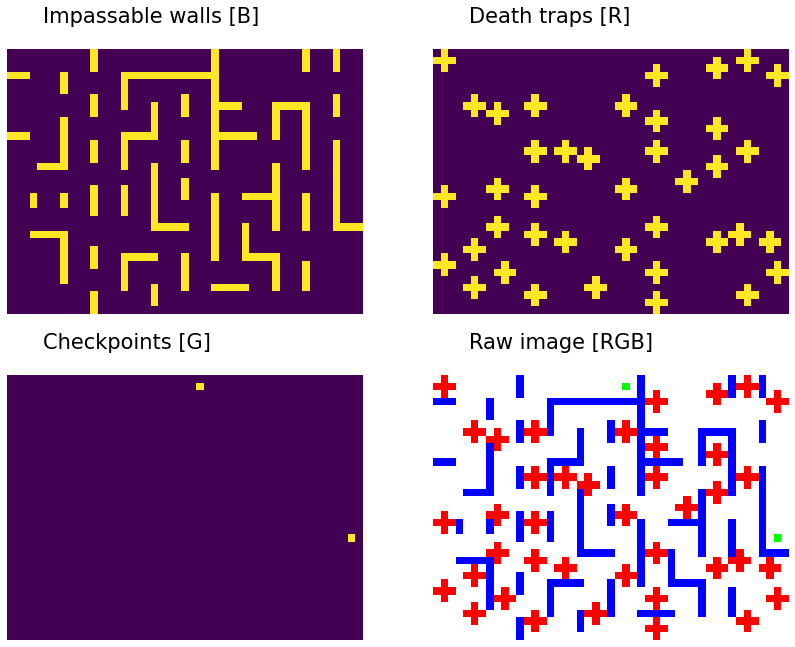

In [2]:
raw_img = plt.imread("./resources/labyrinth_raw.png")
#raw_img = plt.imread("../labyrinth_small.png")

img = np.einsum("WHC->CWH", raw_img)

holes_raw = img[0]
check_raw = img[1]
walls_raw = img[2]

fig, ax = plt.subplots(2,2, figsize=(14,11))
ax = ax.flatten()
[x.set_axis_off() for x in ax]
ax1, ax2, ax3, ax4 = ax.flatten()

fd = {"size": 21}
ax1.imshow(walls_raw)
ax1.text(.1,1.1, "Impassable walls [B]", fontdict=fd,
         transform=ax1.transAxes)
ax2.imshow(holes_raw)
ax2.text(.1,1.1, "Death traps [R]", fontdict=fd,
         transform=ax2.transAxes)
ax3.imshow(check_raw)
ax3.text(.1,1.1, "Checkpoints [G]", fontdict=fd,
         transform=ax3.transAxes)
ax4.imshow(raw_img)
ax4.text(.1,1.1, "Raw image [RGB]", fontdict=fd,
         transform=ax4.transAxes)

plt.show()

holes = list(zip(*np.where(holes_raw!=0)))
walls = list(zip(*np.where(walls_raw!=0)))
check = list(zip(*np.where(check_raw!=0)))
start, finish = check

In [3]:
class Labyrinth2D(gym.Env):
    DEFAULT = {
        "map_arr": plt.imread(
            "./resources/labyrinth_raw.png"
        ), 
        "max_step": None,
        "step_cost": 0.1,
        "visit_scale": 0.1,
        "perma_death": True,
        "death_penalty": -1,
        "victory_score": 10,
    }
    
    def __init__(self, config={}):        
        super(Labyrinth2D, self).__init__()
        self.config = self.DEFAULT.copy()
        for k,v in config.items():
            self.config[k] = v
            
        self.max_step =      self.config["max_step"]
        self.step_cost =     self.config["step_cost"]
        self.visit_scale =   self.config["visit_scale"]
        self.perma_death =   self.config["perma_death"]
        self.death_penalty = self.config["death_penalty"]
        self.victory_score = self.config["victory_score"]
        self.raw_img =       self.config["map_arr"]
        
        self.height, self.width, _ = self.raw_img.shape
        self.num_states = self.height * self.width
        self.yx_states = set([(y, x) 
            for y in range(self.height) 
             for x in range(self.width)
        ])
        
        self.img = np.einsum("WHC->CWH", self.raw_img)
        
        self.action_dict = {
            0: (0,1),  # Right
            1: (1,0),  # Down
            2: (0,-1), # Left
            3: (-1,0)  # Up
        }
        self.world_dict = {
            "holes": list(zip(*np.where(self.img[0]!=0))),
            "check": list(zip(*np.where(self.img[1]!=0))),
            "walls": list(zip(*np.where(self.img[2]!=0)))
        }
        
        self.start, self.finish = self.world_dict["check"]
        
        self.direction = lambda p, a: (p[0]+a[0], p[1]+a[1])
        self.is_legal = lambda s: (s[0]>=0 and s[0]<self.height
                                  ) and (
                                   s[1]>=0 and s[1]<self.width)
        
        self.is_wall = lambda s: s in self.world_dict["walls"]
        self.is_hole = lambda s: s in self.world_dict["holes"]
        
        self.action_space = spaces.Discrete(len(self.action_dict))
        self.observation_space = spaces.Discrete(self.num_states)
        
        self.time = 0
        self.state = None
        self.done = False
        self.visits = None
        
    def flatten_s(self, state):
        return state[0] * self.width + state[1]
    def expand_s(self, state):
        return state // self.width, state % self.width
    
    def reset(self):        
        self.time = 0
        self.done = False
        self.state = self.flatten_s(self.start)
        self.visits = {state: 0 for state in self.yx_states}
        return self.state   
    
    def step(self, action):    
        self.time += 1
        
        state_yx = self.expand_s(self.state)
        move = self.direction(state_yx, self.action_dict[action])
        next_s = move if self.is_legal(move) and not self.is_wall(move) else state_yx
        self.state = self.flatten_s(next_s)
        self.visits[state_yx] += 1
        
        if self.max_step and self.time >= self.max_step:
            count = sum(map(lambda f: f!=0, self.visits.values()))
            reward = -1-(1-count/self.num_states)
            return self.state, -1, True, {}
        
        if self.is_hole(next_s):
            self.state = self.flatten_s(self.start)
            reward = self.death_penalty - self.time
            return self.flatten_s(next_s), self.death_penalty, self.perma_death, {}
            
        if next_s == self.finish:
            return self.state, self.victory_score, True, {}
        
        reward = (self.step_cost*self.visit_scale 
                  if not self.visits[next_s] 
                  else -self.step_cost)
        
        return self.state, reward, False, {}

# Random Agent

Last entry: [1 (7, 14) -1]
Visited states: 43
Total score: -22.18000000000002
Total steps: 260


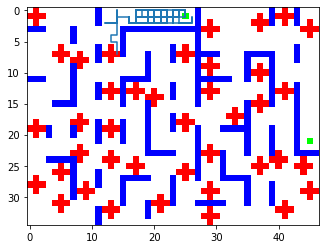

In [4]:
env = Labyrinth2D()
state = env.reset()
history = [(-1, env.expand_s(state), 0)]

done = False; i = 0
while not done and i < 20000:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    history.append((action, env.expand_s(state), reward))
    
    
print("Last entry:", np.array(history)[-1])
print("Visited states:", sum(map(lambda f: f!=0 ,env.visits.values())))
print("Total score:", sum(map(lambda m: m[2], history)))
print("Total steps:", len(history))

plt.imshow(env.raw_img)
plt.plot(*list(zip(*map(lambda m: reversed(m[1]), history))));

# Sample episode

In [5]:
def sample_episode(trainer: agents.Trainer, max_iter=20000, ax=None):
    env = trainer.env_creator(trainer.config["env_config"])
    
    state = env.reset()
    history = [(-1, env.expand_s(state), 0)]
    
    done = False; i = 0
    while not done and i < max_iter:
        action = trainer.compute_action(state)
        state, reward, done, info = env.step(action)
        history.append((action, env.expand_s(state), reward))
        i += 1
        
    print({
        "Sum score": sum(map(lambda m: m[2], history)),
        "Min score": min(map(lambda m: m[2], history)),
        "Max visit": max(env.visits.values()),
        "Length": len(history)
    })
    
    if not ax: fig, ax = plt.subplots()
    ax.imshow(env.raw_img)
    ax.plot(*list(zip(*map(lambda m: reversed(m[1]), history))))
    
    _shape = (env.height, env.width)
    ax.vlines(-.5,-.5,_shape[0]-.5, color="k", lw=2)
    ax.vlines(_shape[1]-.5,-.5,_shape[0]-.5, color="k", lw=2)
    ax.hlines(-.5,-.5,_shape[1]-.5, color="k", lw=2)
    ax.hlines(_shape[0]-.5,-.5,_shape[1]-.5, color="k", lw=2)
    
    if 'fig' in locals(): plt.show()
    return history

# Trainer

Session started... Thu Mar 11 13:33:20 2021
{'Sum score': -1726.1099999995265, 'Min score': -1, 'Max visit': 1156, 'Length': 17593}


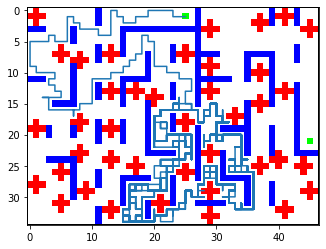

2021-03-11 13:33:37,830	WARNING deprecation.py:33 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!


502 {'Min:': -25.25, 'Mean:': -25.25, 'Max:': -25.25, 'Len:': 458.0}
503 {'Min:': -25.25, 'Mean:': -25.25, 'Max:': -25.25, 'Len:': 458.0}
504 {'Min:': -893.44, 'Mean:': -368.1, 'Max:': -25.25, 'Len:': 3954.0}
505 {'Min:': -893.44, 'Mean:': -294.4, 'Max:': -25.25, 'Len:': 3230.2}
506 {'Min:': -893.44, 'Mean:': -207.92, 'Max:': -14.13, 'Len:': 2353.0}
507 {'Min:': -893.44, 'Mean:': -188.14, 'Max:': -14.13, 'Len:': 2161.64}
{'Sum score': -37.86000000000025, 'Min score': -1, 'Max visit': 112, 'Length': 628}


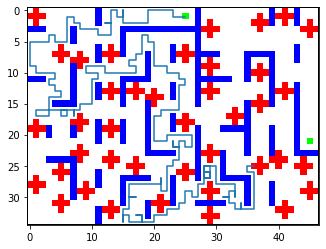

508 {'Min:': -893.44, 'Mean:': -113.03, 'Max:': -6.02, 'Len:': 1389.75}
509 {'Min:': -893.44, 'Mean:': -81.69, 'Max:': -5.62, 'Len:': 1066.83}
510 {'Min:': -893.44, 'Mean:': -60.87, 'Max:': -5.62, 'Len:': 852.09}
511 {'Min:': -893.44, 'Mean:': -48.62, 'Max:': -3.32, 'Len:': 721.91}
{'Sum score': -5.430000000000019, 'Min score': -1, 'Max visit': 24, 'Length': 252}


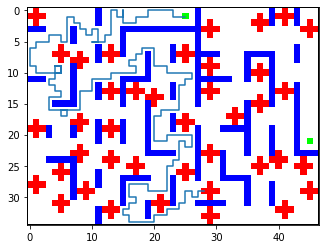

Checkpoint saved at: Thu Mar 11 13:35:10 2021
 /Users/fishm/ray_results/PPO_Labyrinth2D_2021-03-11_13-33-19kng8c9g8/checkpoint_511/checkpoint-511


In [6]:
ray.shutdown(); ray.init()

trainer = agents.ppo.PPOTrainer({
    "env": Labyrinth2D,
    "env_config": {
        "max_step": None,
        "step_cost": 0.1,
        "visit_scale": 0.1,
        "perma_death": True,
        "death_penalty": -1,
        "victory_score": 10
    },
    
    "lr": 3e-5,
    "framework": "torch",
    "num_workers": 0,
    
    "rollout_fragment_length": 512,
    "train_batch_size": 4096,
    
    "num_sgd_iter": 8,
    "vf_clip_param": 10,
    
    "exploration_config": {
        "type": "Curiosity",
        "eta": 0.3,
        "lr": 0.001,
        "feature_dim": 288,
        "feature_net_config": {
            "fcnet_hiddens": [],
            "fcnet_activation": "relu",
        },
        "inverse_net_hiddens": [256],
        "inverse_net_activation": "relu",
        "forward_net_hiddens": [256],
        "forward_net_activation": "relu",
        "beta": 0.2,
        "sub_exploration": {
            "type": "StochasticSampling",
        }
    }
})

trainer.restore(open("labyrinth_2D_500.cpt", "r").read())

clear_output(); print("Session started...", time.ctime())
sample_episode(trainer)

for i in range(10):
    results = trainer.train()
    print(results["training_iteration"], {
        "Min:" :  round(results["episode_reward_min"], 2),
        "Mean:" : round(results["episode_reward_mean"], 2),
        "Max:" :  round(results["episode_reward_max"], 2),
        "Len:" :  round(results["episode_len_mean"], 2),
    })
    
    if i and i%5==0: sample_episode(trainer)
    if i and i%100==0:
        checkpoint = trainer.save()
        print(f"Checkpoint saved at: {time.ctime()}\n", checkpoint)
        with open(f"labyrinth_2D_{i}_F.cpt", "w") as file:
            file.write(checkpoint)
    
sample_episode(trainer)
checkpoint = trainer.save()
print(f"Checkpoint saved at: {time.ctime()}\n", checkpoint)
with open("labyrinth_2D.cpt", "w") as file:
    file.write(checkpoint)
    
ray.shutdown()

### Above is clearly visualised how the new reward signal tackles the circling agent issue
An equal reward/penalty depending on whether the state was previously visited resulted in a zero-sum value  
The new reward signal scales down the step reward which helped the agent maintain a straight course

{'Sum score': -6.590000000000015, 'Min score': -1, 'Max visit': 8, 'Length': 268}
{'Sum score': -14.199999999999989, 'Min score': -1, 'Max visit': 29, 'Length': 365}
{'Sum score': -7.650000000000019, 'Min score': -1, 'Max visit': 17, 'Length': 294}
{'Sum score': -4.90000000000003, 'Min score': -1, 'Max visit': 9, 'Length': 261}


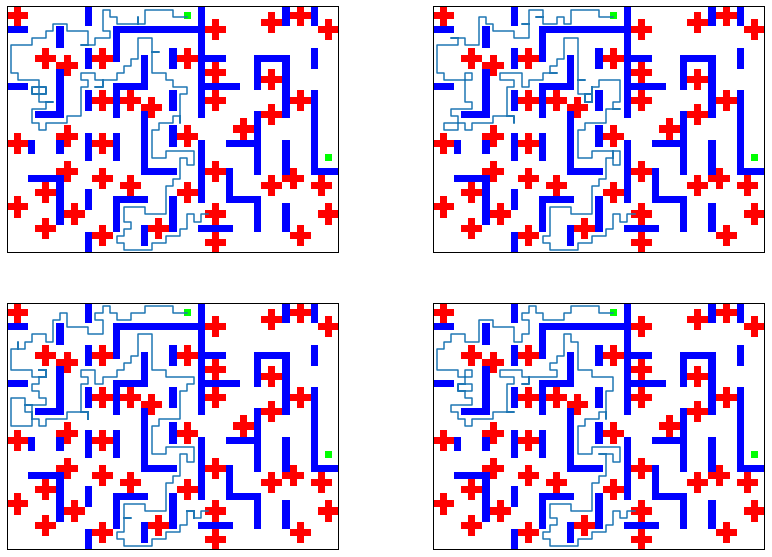

In [7]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
for x in ax.flatten():
    x.set_axis_off()
    sample_episode(trainer, ax=x);